In this notebook we will discuss the regression model's instability in prediction. By instability we do not mean to evaluate how well the model explains the dependent variable. We mean to evaluate how well the model works on two half of our data. This is important in the stock market since, we go through several periods of regime change and a single liner model may not be sufficient to predict the outcome.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm
from statsmodels import regression, stats
import scipy as sp
plt.style.use('fivethirtyeight')

In [2]:
def linreg(X,Y):
    
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(Y,x).fit()
    
    return model.params[0], model.params[1]
    

Slope is : -0.0005852991335879693
Intercept is : 0.05601072149668786


''

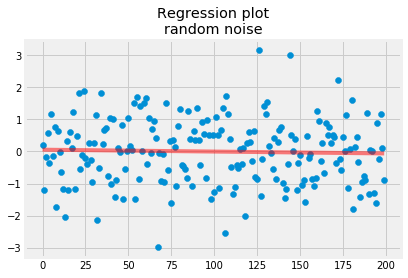

In [3]:
rand = np.random.randn(200)

xs = np.arange(200)

a,b = linreg(xs,rand)

print(f"Slope is : {b}")
print(f"Intercept is : {a}")

plt.scatter(xs,rand)
y_hat = a + (b * xs)
plt.plot(xs,y_hat, color = 'red', alpha = 0.5)
plt.title("Regression plot\nrandom noise")
;

## Regime Changes

In [4]:
spy = pdr.get_data_yahoo('SPY', '2003-1-1', '2009-04-01')

In [5]:
spy = spy['Adj Close']

In [6]:
spy.head()

Date
2003-01-02    65.088028
2003-01-03    65.288132
2003-01-06    66.438843
2003-01-07    66.274452
2003-01-08    65.316711
Name: Adj Close, dtype: float64

Text(0, 0.5, 'Price')

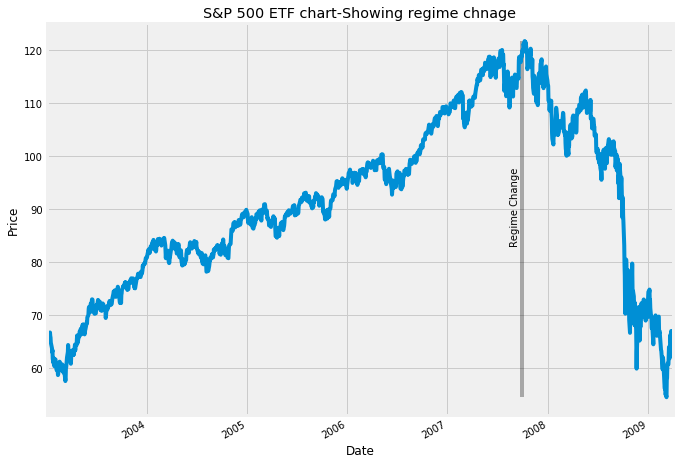

In [7]:
plt.figure(figsize=(10,8))
spy.plot()
plt.vlines(pd.datetime(2007,10,1), ymin=spy.min(),ymax = spy.max(),color = 'Black', alpha = 0.3)
plt.annotate("Regime Change", xy=(510, 220), xycoords='figure points', rotation = 90)
plt.title("S&P 500 ETF chart-Showing regime chnage")
plt.ylabel('Price')

Divide the data into the two regimes.

In [8]:
regime1 = spy.loc[:'2007-10-1']
regime2 = spy.loc['2007-10-1':]

''

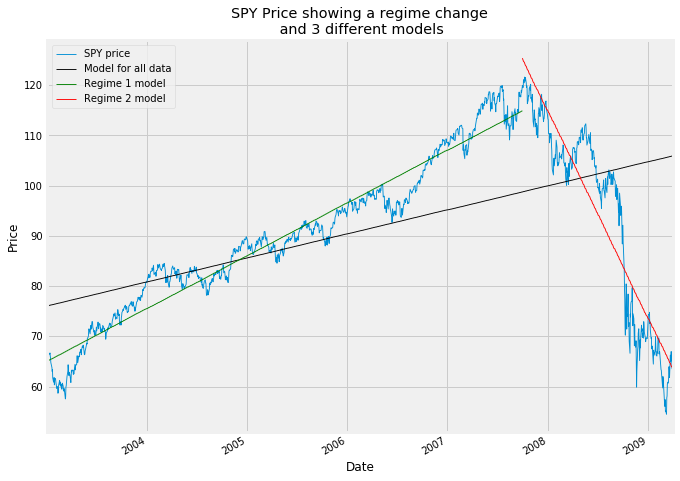

In [9]:
a,b = linreg(np.arange(len(spy)), spy)
a1,b1 = linreg(np.arange(len(regime1)), regime1)
a2,b2 = linreg(np.arange(len(regime2)), regime2)

y_hat = pd.Series(a + b * np.arange(len(spy)), index = spy.index)
y1_hat = pd.Series(a1 + b1 * np.arange(len(regime1)), index = regime1.index)
y2_hat = pd.Series(a2 + b2 * np.arange(len(regime2)), index = regime2.index)

spy.plot(figsize=(10,8),linewidth = 0.9)
plt.plot(y_hat,color = 'black', linewidth = 0.9)
plt.plot(y1_hat,color = 'green',linewidth = 0.9)
plt.plot(y2_hat,color = 'red', linewidth = 0.9)
plt.title('SPY Price showing a regime change\n and 3 different models')
plt.ylabel('Price')
plt.legend(['SPY price', 'Model for all data', 'Regime 1 model', 'Regime 2 model'])
;

A regime change can be seen in the above chart. We have split the data into 3 parts and fit 3 different models to the data. We can see that after 2007 the model(black) does not fit the data well and the model (Red) is more appropriate. But it is difficult to predict such a regime change in the stock market.<br>
Breaking the data down into further smaller pieces would fit the model even more perfectly. But we should be cautious, as this would be overfitting the data. Such a model can train well on the old data, but would fail to generalize well on new data.

### Multicollinearity

So far we have only considered the regression of one dependent variable. However often, there are multiple independent variables that are highly correlated. In the case of multicollinearity, the estimate of one variable's effect on the dependent variable becomes less precise even after controlling the other independent variable. Such cases can lead to instability of our prediction and overfitting caused by redundant variables.

In [10]:
start = '2013-01-01'
end = '2015-01-01'
b1 = pdr.get_data_yahoo('SPY', start=start, end=end)['Adj Close']
b2 = pdr.get_data_yahoo('MDY', start=start, end=end)['Adj Close']
asset = pdr.get_data_yahoo('V', start=start, end=end)['Adj Close']

We can calculate the beta and plot the multiple linear regression of Visa stock to two different benchmarks.

Constant: -16.78217434177884 
MLR beta to S&P 500: 0.30669932370118524  
MLR beta to MDY 0.06902862882937501


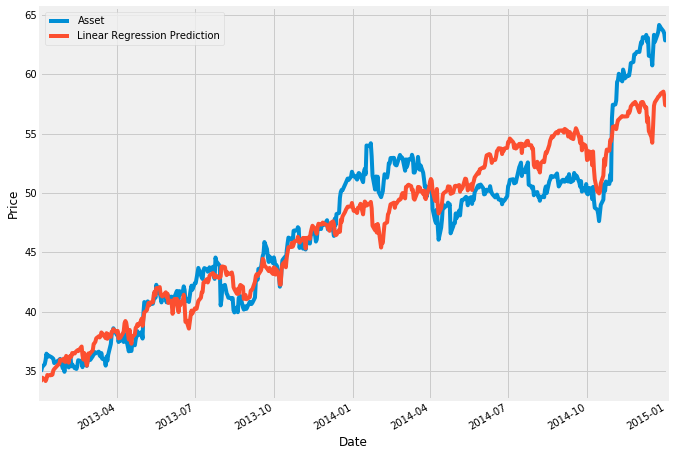

In [11]:
mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print('Constant:', mlr.params[0], '\nMLR beta to S&P 500:', mlr.params[1], ' \nMLR beta to MDY', mlr.params[2])

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot(figsize=(10,8))
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction']);

If extent the period to June 2015 the beta will change as well.

In [12]:
start = '2013-01-01'
end = '2015-06-01'
b1 = pdr.get_data_yahoo('SPY', start=start, end=end)['Adj Close']
b2 = pdr.get_data_yahoo('MDY', start=start, end=end)['Adj Close']
asset = pdr.get_data_yahoo('V', start=start, end=end)['Adj Close']

Constant: -28.541620131968912 
MLR beta to S&P 500: 0.24472022734960938  
MLR beta to MDY 0.17111020654354417


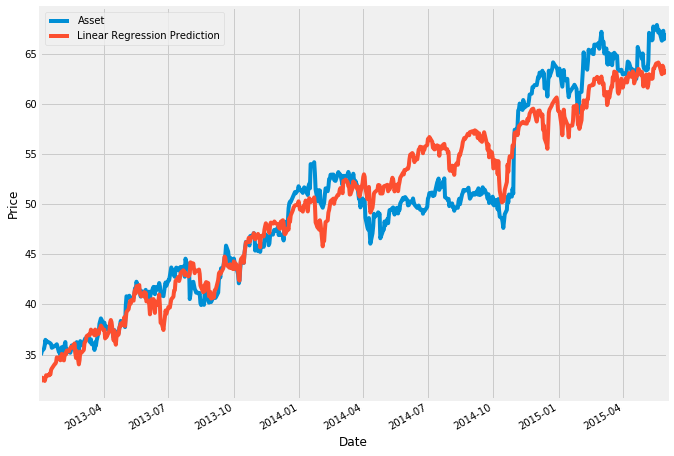

In [13]:
mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print('Constant:', mlr.params[0], '\nMLR beta to S&P 500:', mlr.params[1], ' \nMLR beta to MDY', mlr.params[2])

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot(figsize=(10,8))
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction']);

We can see that beta to SPY decreased, but the beta to MDY increased from 0.06 to 0.17

We can check that our indepent variables are highly correlated.

In [14]:
print(f"Beta of SPY and MDY is {sp.stats.pearsonr(b1,b2)[0]}")

Beta of SPY and MDY is 0.9898677377072611
